# Building Explainable Machine Learning Models
## Exercise: Explaining models with Occlusion

LIME stands for Local Interpretable Model-Agnostic Explanations) 
It generates an explanation by approximating the underlying model by an interpretable one.


During this exercise,  you are going to be using Occlusion technique  on pretrained ResNet model using an image. You’ll then visualize the attributions of every pixel in the images to understand what it is that the model is looking for in the image to make a specific prediction

To implement the Occulusion method, we’ll use Captum. Captum is a model interpretability library built on PyTorch and supports many models out of the box. It offers implementations of many interpretability algorithms that can work seamlessly with various Pytorch models.


Let's get started!

# Occlusion


![](https://imgur.com/rATDU6q.png)

source: [Documentation of LIME](https://captum.ai/api/occlusion.html)



---

# Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [69]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import Occlusion

from captum.attr import visualization as viz
import warnings  
warnings.filterwarnings("ignore")

### Load the Imagenet dataset labels

In [70]:
labels_path = '../data/imagenet_class_index (2).json'

with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [71]:
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

### Preprocess Dataset

In [72]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )



In [73]:
img = Image.open('../data/puppy.jpeg')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

### Loading the model

In [74]:
model = models.resnet18(pretrained=True)
model = model.eval()

#### Predict the class of the input image

In [75]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tennis_ball ( 0.7360450029373169 )


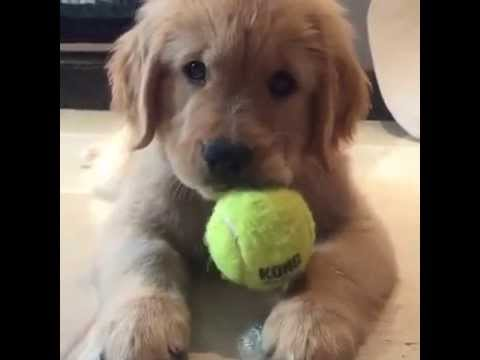

In [76]:
test_img = Image.open('../data/puppy.jpeg').convert('RGB')
test_img 

## Occlusion based Attribution

We run a sliding window of size 15x15 (defined via sliding_window_shapes) with a stride of 8 along both image dimensions (a defined via strides). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via baselines).[Source](https://github.com/pytorch/captum/blob/master/tutorials/Resnet_TorchVision_Interpret.ipynb)

In [77]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

### Visualizing attribution with positive attribution

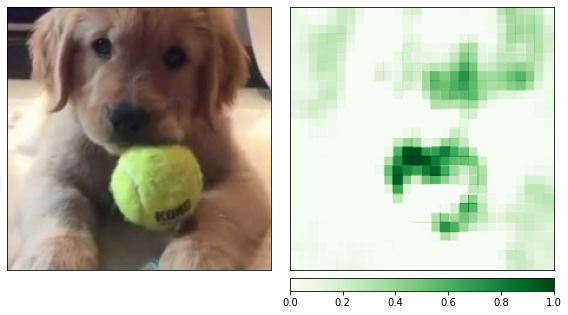

In [78]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

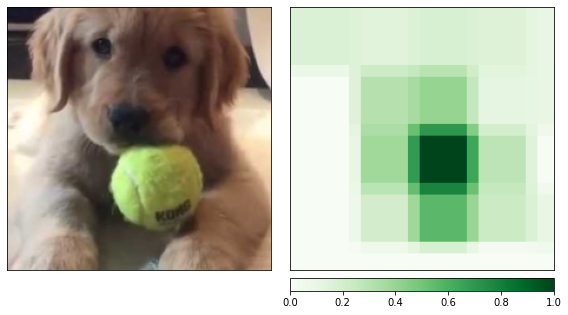

In [79]:
# occluding the image using a larger sliding window
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

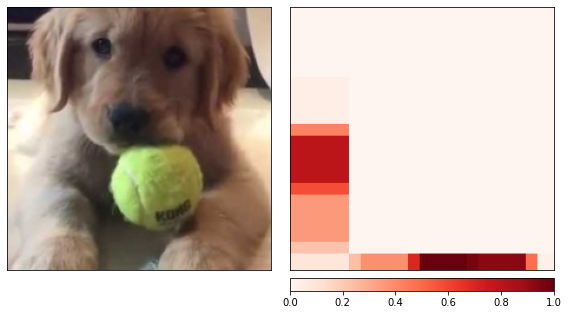

In [80]:
### Visualizing attribution with negative attribution
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "negative"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )